In [1]:
#reload source files automatically
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score as acc
import numpy as np
from lime import explanation
from lime import lime_base
from lime_timeseries import LimeTimeSeriesExplanation
import math

## Load Coffee Dataset

In [3]:
coffee_train = pd.read_csv('coffee_train.csv', sep=',', header=None).astype(float)
coffee_train_y = coffee_train.loc[:, 0]
coffee_train_x = coffee_train.loc[:, 1:]
coffee_test = pd.read_csv('coffee_test.csv', sep=',', header=None).astype(float)
coffee_test_y = coffee_test.loc[:, 0]
coffee_test_x = coffee_test.loc[:, 1:]

## Load ECG Dataset

In [4]:
ecg_train = pd.read_csv('ecg_test.csv', sep=',', header=None).astype(float)
ecg_train.replace([np.inf, -np.inf], np.nan).dropna()
ecg_train = ecg_train.loc[:186, :]
ecg_train_y = ecg_train.loc[:, 0]
ecg_train_x = ecg_train.loc[:, 1:]
ecg_test = pd.read_csv('ecg_train.csv', sep=',', header=None).astype(float)
ecg_test.replace([np.inf, -np.inf], np.nan).dropna()
ecg_test_y = ecg_test.loc[:, 0]
ecg_test_x = ecg_test.loc[:, 1:]

## Datasets

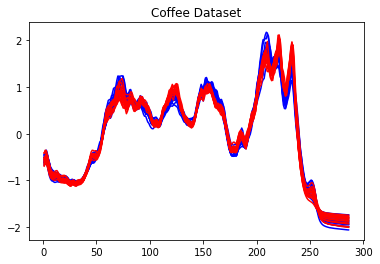

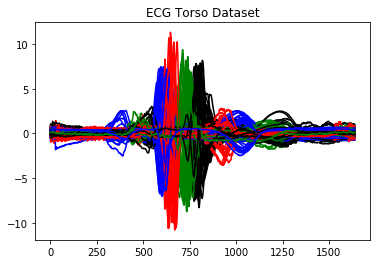

In [5]:
for idx in range(0, len(coffee_train)):
    if coffee_train_y[idx] == 0:
        plt.plot(coffee_train_x.loc[idx, :], 'b')
    else:
        plt.plot(coffee_train_x.loc[idx, :], 'r')
plt.title('Coffee Dataset')
plt.show()

for idx in range(0, len(ecg_train)):
    if ecg_train_y[idx] == 4:
        plt.plot(ecg_train_x.loc[idx, :], 'b')
    elif ecg_train_y[idx] == 1:
        plt.plot(ecg_train_x.loc[idx, :], 'r')
    elif ecg_train_y[idx] == 2:
        plt.plot(ecg_train_x.loc[idx, :], 'g')
    elif ecg_train_y[idx] == 3:
        plt.plot(ecg_train_x.loc[idx, :], 'black')
plt.title('ECG Torso Dataset')
plt.show()

### Compute Accuracy

In [6]:
knn = KNN()
knn.fit(coffee_train_x, coffee_train_y)
knn2 = KNN()
knn2.fit(ecg_train_x, ecg_train_y)
print('Accuracy KNN for coffee dataset: %f' % (acc(coffee_test_y, knn.predict(coffee_test_x))))
print('Accuracy KNN for earthquake dataset: %f' % (acc(ecg_test_y, knn2.predict(ecg_test_x))))

Accuracy KNN for coffee dataset: 0.964286
Accuracy KNN for earthquake dataset: 0.900000


## Explaining Coffee Dataset

In [7]:
idx = 5
num_features = 10
num_slices = 24
series = coffee_test_x.iloc[idx, :]

In [8]:
explainer = LimeTimeSeriesExplanation(class_names=['0', '1'], feature_selection='auto')
exp = explainer.explain_instance(series, knn.predict_proba, num_features=num_features, num_samples=5000, num_slices=num_slices, 
                                 replacement_method='total_mean', training_set=coffee_train_x)
exp.as_list()

[(17, -0.4012229084412328),
 (18, 0.3305846780405982),
 (19, 0.3122738056485388),
 (13, -0.2202300570716247),
 (6, -0.17176376622286227),
 (20, 0.1582491932585081),
 (10, 0.1348998580194135),
 (12, -0.13002177150758687),
 (22, -0.12522388458017467),
 (23, -0.1201509375496332)]

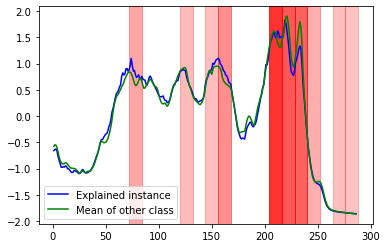

In [9]:
values_per_slice = math.ceil(len(series) / num_slices)
plt.plot(series, color='b', label='Explained instance')
plt.plot(coffee_test_x.iloc[15:,:].mean(), color='green', label='Mean of other class')
plt.legend(loc='lower left')
for i in range(num_features):
    feature, weight = exp.as_list()[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    plt.axvspan(start , end, color='red', alpha=abs(weight*2))
plt.show()

## Explaining ECG Dataset

In [10]:
idx_ecg = 7
num_features_ecg = 5
num_slices_ecg = 17
series_ecg = ecg_test_x.iloc[idx_ecg, :]

In [11]:
explainer2 = LimeTimeSeriesExplanation(class_names=['0', '1'], feature_selection='auto')
exp2 = explainer2.explain_instance(series_ecg, knn2.predict_proba, num_features=num_features_ecg, num_samples=500, num_slices=num_slices_ecg, 
                                 replacement_method='noise', training_set=ecg_train_x)
exp2.as_list()

[(6, -0.09640249303093561),
 (7, -0.07152925701349172),
 (8, -0.020479661892267926),
 (1, -0.018784588684859407),
 (13, 0.014219034496087805)]

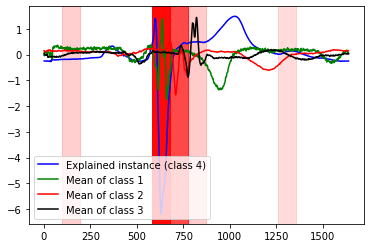

In [12]:
values_per_slice_ecg = math.ceil(len(series_ecg) / num_slices_ecg)
plt.plot(series_ecg, 'b', label='Explained instance (class 4)')
plt.plot(ecg_test_x.iloc[ecg_test_y[ecg_test_y == 1].index, :].mean(), color='green',
        label='Mean of class 1')
plt.plot(ecg_test_x.iloc[ecg_test_y[ecg_test_y == 2].index, :].mean(), color='red',
        label='Mean of class 2')
plt.plot(ecg_test_x.iloc[ecg_test_y[ecg_test_y == 3].index, :].mean(), color='black',
        label='Mean of class 3')
for i in range(num_features_ecg):
    feature, weight = exp2.as_list()[i]
    start = feature * values_per_slice_ecg
    end = start + values_per_slice_ecg
    plt.axvspan(start , end, color='red', alpha=abs(weight*10))
plt.legend(loc='lower left')
plt.show()